<a href="https://colab.research.google.com/github/iN8mare/DeepLabV3Plus_different_encoders_pytorch/blob/main/DeeplabV3Plus_with_ResNet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.nn import Conv2d, BatchNorm2d, ReLU, AvgPool2d, UpsamplingBilinear2d, Sigmoid
from PIL import Image
from torchvision import transforms
import torchsummary

In [30]:
ENCODERS = {
    "ResNet 50" : torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2),
}

INPUT_SHAPE = (1, 3, 256, 256)

In [39]:
class DeepLabV3Plus(nn.Module):
    def __init__(self, pretrained_encoder = 'ResNet 50'):
        super().__init__()

        self.features = {}
        self.encoder = ENCODERS[pretrained_encoder]
        # print([n for n, _ in self.encoder.named_children()])


    def get_features(self, name):
        def hook(model, input, output):
            self.features[name] = output.detach()
        return hook


    def create_encoder(self, image_features):
        '''
        Creates the entire encoder of our model
        image_features : Tensor -> The high level features extracted via hooks from EfficientNet B6
        '''
        y_1 = Conv2d(image_features.shape[1], 256, kernel_size = 1, padding = 'same', dilation = 1, bias = False)(image_features)
        y_1 = BatchNorm2d(256)(y_1)
        y_1 = ReLU(inplace=True)(y_1)
        # print(y_1.shape)

        y_6 = Conv2d(image_features.shape[1], 256, kernel_size = 3, padding = 'same', dilation = 6, bias = False)(image_features)
        y_6 = BatchNorm2d(256)(y_6)
        y_6 = ReLU(inplace=True)(y_6)
        # print(y_6.shape)

        y_12 = Conv2d(image_features.shape[1], 256, kernel_size = 3, padding = 'same', dilation = 12, bias = False)(image_features)
        y_12 = BatchNorm2d(256)(y_12)
        y_12 = ReLU(inplace=True)(y_12)
        # print(y_12.shape)

        y_18 = Conv2d(image_features.shape[1], 256, kernel_size = 3, padding = 'same', dilation = 18, bias = False)(image_features)
        y_18 = BatchNorm2d(256)(y_18)
        y_18 = ReLU(inplace=True)(y_18)
        # print(y_18.shape)

        y_pool = AvgPool2d(kernel_size = (image_features.shape[2], image_features.shape[3]))(image_features)
        y_pool = Conv2d(image_features.shape[1], 256, kernel_size = 1, padding = 'same', dilation = 1, bias = False)(y_pool)
        y_pool = ReLU(inplace=True)(y_pool)
        y_pool = UpsamplingBilinear2d((image_features.shape[2], image_features.shape[3]))(y_pool)
        # print(y_pool.shape)

        y_concatenated = torch.cat([y_1, y_6, y_12, y_18, y_pool], dim=1)
        # print(y_concatenated.shape)

        y_concatenated = Conv2d(y_concatenated.shape[1], 256, kernel_size = 1, padding = 'same', dilation = 1, bias = False)(y_concatenated)
        y_concatenated = BatchNorm2d(256)(y_concatenated)
        y_concatenated = ReLU(inplace=True)(y_concatenated)
        y_concatenated = UpsamplingBilinear2d((y_concatenated.shape[2]*4, y_concatenated.shape[3]*4))(y_concatenated)
        # print(y_concatenated.shape)

        return y_concatenated


    def create_decoder(self, low_features, encoder_output):
        '''
        Creates the decoder part of our model.
        low features : Tensor -> the low level features extracted via hooks from EfficientNet B6
        encoder_output : Tensor -> will be concatenated with low level features (refer diagram in README)
        '''
        # print("encoder")

        x = Conv2d(low_features.shape[1], 128, kernel_size = 1, padding = 'same', dilation = 1, bias = False)(low_features)
        x = BatchNorm2d(128)(x)
        x = ReLU(inplace=True)(x)
        # print(x.shape)

        y_concat = torch.cat([x, encoder_output], dim=1)
        # print(y_concat.shape)

        x = Conv2d(y_concat.shape[1], 256, kernel_size = 3, padding = 'same', dilation = 1, bias = False)(y_concat)
        x = BatchNorm2d(256)(x)
        x = ReLU(inplace=True)(x)
        # print(x.shape)

        x = UpsamplingBilinear2d((x.shape[2]*4, x.shape[3]*4))(x)
        x = Conv2d(x.shape[1], 1, kernel_size = 1, padding = 'same', dilation = 1, bias = False)(x)
        x = Sigmoid()(x)
        # print(x.shape)

        return x


    def forward(self, input):
        self.encoder.layer3[2].register_forward_hook(self.get_features('deep_features')) # Hook to extract high level features
        self.encoder.layer1[2].register_forward_hook(self.get_features('low_features'))  # Hook to extract low level features
        self.encoder.layer1[2].register_forward_hook(self.get_features('low_features'))
        self.encoder(input)
        encoder_output = self.create_encoder(self.features['deep_features'])
        final_output = self.create_decoder(self.features['low_features'], encoder_output)
        return final_output

In [37]:
a = DeepLabV3Plus('ResNet 50')
print(a(torch.randn(INPUT_SHAPE))) # providing a random tensor of INPUT_SHAPE

tensor([[[[0.7045, 0.6651, 0.6234,  ..., 0.6815, 0.6259, 0.5667],
          [0.7425, 0.7026, 0.6594,  ..., 0.6505, 0.5967, 0.5405],
          [0.7772, 0.7376, 0.6937,  ..., 0.6181, 0.5668, 0.5140],
          ...,
          [0.6366, 0.6278, 0.6190,  ..., 0.6237, 0.6024, 0.5807],
          [0.6328, 0.6235, 0.6141,  ..., 0.6370, 0.6250, 0.6129],
          [0.6290, 0.6192, 0.6093,  ..., 0.6501, 0.6471, 0.6441]]]],
       grad_fn=<SigmoidBackward0>)


In [35]:
def test_with_img(img_path):
    img = Image.open(img_path)
    image_to_tensor = transforms.Compose([
                transforms.Resize((INPUT_SHAPE[2], INPUT_SHAPE[3])),
                transforms.ToTensor(),
                ])

    img_tensor = image_to_tensor(img).unsqueeze(dim=0)
    model = DeepLabV3Plus('ResNet 50')
    output = model(img_tensor)

    tensor_to_img = transforms.ToPILImage()
    img = tensor_to_img(output.squeeze(dim=0))
    display(img)

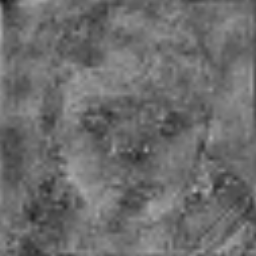

In [36]:
test_with_img("/content/image.jpg")